# 1.) Import an asset price from Yahoo Finance

In [1]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 883.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 KB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 4.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
  

In [6]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


########################################
####Pick your ticker and time period####
########################################
stock_data = yf.download("TCEHY", start="2001-01-01", end="2022-02-24")



# Preprocess data
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)


# Split data into training and test sets
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]



[*********************100%***********************]  1 of 1 completed


# 2.) Create your x_train/y_train data so that your RNN uses percentage change data to make a binary forecast where the stock moves up or down the next day
# Build an RNN Architecture accordingly

In [30]:
x_train = []
y_train = []


#############################################################
####Pick your input size and edit to make binary forecast####
#############################################################
input_size = 5
for i in range(input_size, len(train_data)):
    x_train.append(train_data[i-input_size:i, 0])
    y_train.append(train_data[i, 0])


x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

###################################
####Build Your RNN Architecture####
###################################
model = Sequential()
model.add(LSTM(x_train.shape[1], return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=3)

Epoch 1/3
2439/2439 [==============================] - 23s 8ms/step - loss: 4.6288e-04
Epoch 2/3
2439/2439 [==============================] - 17s 7ms/step - loss: 4.5537e-04
Epoch 3/3
2439/2439 [==============================] - 16s 6ms/step - loss: 4.6024e-04


# 3.) Test your model and compare insample Accurracy, insample random walk assumption Accuracy, Out of sample Accuracy and out of sample random walk assumption Accuracy using a bar chart

In [31]:

test_data = scaled_data[training_data_len - input_size:, :]

x_test = []
y_test = np.array(stock_data[["Close"]].pct_change().dropna())[training_data_len:, :]
for i in range(input_size, len(test_data)):
    x_test.append(test_data[i-input_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)

20/20 [==============================] - 2s 6ms/step


In [32]:
# Our model IN Accuracy
predictions1 = model.predict(x_train)
in_mse = np.mean((y_train - predictions1) ** 2)
in_rmse = np.sqrt(np.mean((y_train - predictions1) ** 2))
print("The in sample MSE and RMSE of our model are:",in_mse,"and",in_rmse)

77/77 [==============================] - 0s 4ms/step
The in sample MSE and RMSE of our model are: 0.0004474821020735927 and 0.02115377276217159


In [33]:
#  Our model OSS Accuracy
oss_mse = np.mean((y_test - predictions) ** 2)
oss_rmse = np.sqrt(np.mean((y_test - predictions) ** 2))
print("The out of sample MSE and RMSE of our model are:",oss_mse,"and",oss_rmse)

The out of sample MSE and RMSE of our model are: 0.0006501751073909888 and 0.02549853147518478


In [34]:
# Random Walk Model IN Accuracy
in_mse_rw = np.mean((y_train[1:] - y_train[:-1]) ** 2)
in_rmse_rw = np.sqrt(np.mean((y_train[1:] - y_train[:-1]) ** 2))
print("The in sample MSE and RMSE of Random Walk Model are:",in_mse_rw ,"and",in_rmse_rw )

# Random Walk Model OSS Accuracy
oss_mse_rw = np.mean((y_test[1:] - y_test[:-1]) ** 2)
oss_rmse_rw = np.sqrt(np.mean((y_test[1:] - y_test[:-1]) ** 2))
print("The out of sample MSE and RMSE of Random Walk Model are:",oss_mse_rw ,"and",oss_rmse_rw )

The in sample MSE and RMSE of Random Walk Model are: 0.0009003442376017356 and 0.030005736744858232
The out of sample MSE and RMSE of Random Walk Model are: 0.0014990637617866352 and 0.03871774479210579


<BarContainer object of 2 artists>

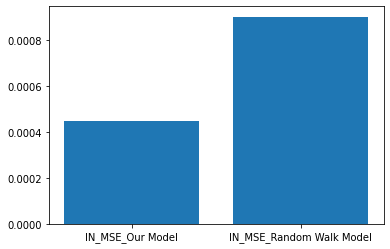

In [38]:
import matplotlib.pyplot  as plt

plt.bar(["IN_MSE_Our Model","IN_MSE_Random Walk Model",],[in_mse,in_mse_rw])

<BarContainer object of 2 artists>

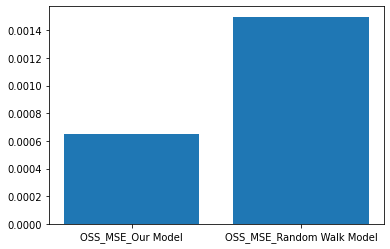

In [39]:
plt.bar(["OSS_MSE_Our Model","OSS_MSE_Random Walk Model",],[oss_mse,oss_mse_rw])

# 4.) Plot in and out of sample accuracy
# No more

In [ ]:
import matplotlib.pyplot as plt

# Make predictions on full dataset

test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * np.cumprod(y_test+1)

train_predict = model.predict(x_train)
train_predictions = (train_predict+1).reshape(1,-1) * np.cumprod(y_train+1)



plt.plot(stock_data[:training_data_len- input_size].index, np.cumprod(y_train+1), label="Training Data")
plt.plot(stock_data[:training_data_len- input_size].index, train_predictions[0], label="Training Predictions")
end_val = np.cumprod(y_train+1)[-1]
test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * (np.cumprod((y_test+1))*end_val)
plt.plot(stock_data[training_data_len+1:].index, np.cumprod((y_test+1))*end_val,label="Test Data")
plt.plot(stock_data[training_data_len+1:].index, test_predictions[0], label="Test Predictions")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

#5.) Write an observation/conclusion about the graphs from Q4 and Q3

I can find that our model has a better performance than the random walk model. As you can see, the bar chart shows our model has smaller mean squared error and also smaller sqrt mean squarred error. I think it is because that the price of Tencent has certain parttern and trend rather than just random walking

# 6.) Create a parameter for number of lags in your input layer. Do a 3-fold CV to test three different time lags. i.e. Tested using 5,10,20 days of previous price data to forecast

In [47]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor

# Define the Keras model

def create_model(input_size):
    model = Sequential()
    model.add(Dense(10, input_dim=input_size, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return(model)

# Wrap the Keras model in a scikit-learn compatible estimator，for us to use scikit-learn's tools for hyperparameter tuning, cross-validation, and evaluation.
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the hyperparameters to search over
param_grid = {'epochs': [10, 100], 'input_size':[5,15,20]}

# Perform the grid search over the hyperparameters
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

# Print the results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

<ipython-input-47-e4ac251b3840>:15: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
12 fits failed out of a total of 18.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8

Best: -0.008795 using {'epochs': 100, 'input_size': 5}
